In [1]:
import pandas as pd
import sys
import csv
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan as nan
from qtrendutils import isd_utils as isd
from datetime import datetime

In [2]:
ystart=1980 ; yend=2020 ; nyears=yend-ystart+1

In [3]:
### Setting up the output calendar dates
timeout = pd.date_range(start=str(ystart)+"-01-01",end=str(yend)+"-12-31")
### Remove Feb 29th
timeout = timeout[~((timeout.month == 2) & (timeout.day == 29))]

monstrings=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
datpath="/project/mojave/observations/ISD/hourly/"
#datpath="https://www.ncei.noaa.gov/data/global-hourly/archive/csv/"
statfile="/project/mojave/observations/ISD/global-summary-of-the-day/isd-history.txt"
inventfile="/project/mojave/observations/ISD/global-summary-of-the-day/isd-inventory.csv"
fileout="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/ISD/1980_2020/T2M_DEW_ISD_global_fromhourly_1980_2020.nc"

In [4]:
#---Set up the character locations of the required columns from the idf-history.txt file
datestart=[82,90] 
dateend=[91,99]
latstr=[57,64]
lonstr=[65,73]
usafstr=[0,6]
wbanstr=[7,12]

#---Open the isd-history file and gab out the relevant station information
f = open(statfile,"r")
# skip header
for i in range(22):
    f.readline()

#sys.exit()
usaf=[] ; wban=[] ; dates=[] ; datee=[] ; lon=[] ; lat=[]
count=0
for line in f:
    dates.append(line[datestart[0]:datestart[1]])
    datee.append(line[dateend[0]:dateend[1]])
    lon.append(line[lonstr[0]:lonstr[1]])
    lat.append(line[latstr[0]:latstr[1]])
    usaf.append(line[usafstr[0]:usafstr[1]])
    wban.append(line[wbanstr[0]:wbanstr[1]])
f.close()


In [5]:
dictstat=[{'wban': wban, 'usaf': usaf, 'lat': lat, 'lon':lon, 'dates':dates, 'datee':datee} 
     for wban, usaf, lat, lon, dates, datee in zip (wban, usaf, lat, lon, dates, datee)]

In [9]:
inventory = pd.read_csv(inventfile)

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [303]:
#inventory = pd.read_csv(inventfile)

#statuse=[]
#statname=[]
#usaf=[]
#wban=[]
#latstation=[]
#lonstation=[]

#for key in dictstat:
#    try:
#        latflt=float(key['lat'])
#    except:
#        latflt=-9999.
#        
#    try: 
#        lonflt=float(key['lon'])
#    except:
#        lonflt=-9999.
#        
#    try:
#        usafval = int(key['usaf'])
#    except:
#        usafval = key['usaf']
#        
#    inventdat = inventory.loc[inventory['USAF']==usafval]
#    statyears = inventdat.loc[(inventdat['YEAR'] >= ystart) & (inventdat['YEAR'] <= yend)]
#    statyears = statyears['YEAR']
    
#    datebegflt = float(key['dates'])
#    dateendflt = float(key['datee'])
    
#    if (  (datebegflt < ystart*10000) and (dateendflt >= (yend*10000+1)) and (len(statyears) == nyears)):
#        statuse.append(key)
#        statname.append(key['usaf']+key['wban'])
#        usaf.append(key['usaf'])
#        wban.append(key['wban'])
#        latstation.append(latflt)
#        lonstation.append(lonflt)        

In [6]:
datevals=pd.date_range(start="1979-01-01",end="1979-12-31")
m = np.array(datevals.month)
mm = np.char.zfill(m.astype(str),2)
d = np.array(datevals.day)
dd = np.char.zfill(d.astype(str),2)
datestrings=[mmm + "-" +  ddd  for  mmm, ddd in zip(mm, dd) ]

In [242]:
# Read in the data for stations that will be used
#t2m = np.empty([len(statname), nyears*365])
#t2m[:,:] = nan
#dewp = np.empty([len(statname), nyears*365])
#dewp[:,:] = nan
#stp = np.empty([len(statname), nyears*365])
#stp[:,:] = nan

In [140]:
statname=['72268023009', '72268793033', '72274023160', '72278023183',
       '72278623104', '72290023188', '72290693112', '72290993115',
       '72292603154', '72295023174', '72297023129', '72360023051',
       '72362723081', '72365023050', '72367723054', '72374023194',
       '72380523179', '72381523161', '72381603159', '72383023187',
       '72384023155', '72386023169', '72389093193', '72391093111',
       '72392523190', '72394023273', '72396593209', '72463523067',
       '72464093058', '72464523070', '72466093037', '72475593129',
       '72476023066', '72480023157', '72483023232', '72485523153',
       '72486023154', '72488023185', '72488593102', '72492023237',
       '72492623258', '72494523293', '72572024127', '72582524121',
       '72583024128', '72591024216', '72594524283', '74612093104',
       '74702023110', '74718703104', '74718823158']

#statname=['74702023110']
#statname=['72278623104']
#statname=['72268023009', '72268793033']

In [141]:
usecols=['SOURCE', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 'DATE', 'DEW', 'TMP']

has_data = np.ones(len(statname)).astype(bool)
dat_stations=[]
dat_stations_hourly=[]

for istat in range(0,len(statname),1):
    print(str(istat)+':'+statname[istat])

    usafval = int(usaf[istat])
    wbanval = int(wban[istat])
    inventdat = inventory.loc[inventory['USAF']==usafval]
    statyears = inventdat.loc[(inventdat['YEAR'] >= ystart) & (inventdat['YEAR'] <= yend)]
    statyears = statyears['YEAR']
    
    alldat=[]
    
    for iyear in range(ystart,yend+1,1):
        fname = datpath+str(iyear)+'/'+statname[istat]+'.csv'
            
        try:    
            data = pd.read_csv(fname, usecols=usecols, low_memory=False) 
            data = isd.remove_bad_rows(data)
            data = data[['DATE','TMP','DEW']]
            for varname in ('TMP','DEW'):
                data = isd.remove_bad_vals(data, varname)
        
            alldat.append(data)
        except:
            pass

            
    if len(alldat) > 0:
        alldat = pd.concat(alldat, ignore_index=True).reset_index()
        alldat = alldat[['DATE','TMP','DEW']]
    else:
        has_data[istat]=False
        #date_data = data[['DATE','TMP','DEW','SOURCE','REPORT_TYPE','CALL_SIGN','QUALITY_CONTROL']]
    
    dt = [datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') for d in alldat['DATE']]
    alldat.index = dt
    
    #-----check the first and last days are in the record.  If not - pad it with a NaN
    #-----check the first and last days are in the record.  If not - pad it with a NaN
    if ( (alldat.index.year[0] != ystart) | (alldat.index.month[0] != 1) | (alldat.index.day[0] != 1) ):
        day1 = datetime.strptime(str(ystart)+"-01-01", '%Y-%m-%d')
        datday0 = pd.DataFrame(data=[[nan, nan]], index=[day1], columns=['TMP', 'DEW'])
        alldat= pd.concat([datday0, alldat])
    
    if ( (alldat.index.year[len(alldat.index)-1] != yend) | (alldat.index.month[len(alldat.index)-1] != 12) | 
       (alldat.index.day[len(alldat.index)-1] != 31) ):
        dayend = datetime.strptime(str(yend)+"-12-31",'%Y-%m-%d')
        alldat = pd.concat([alldat, dayend])
                

    #-----test for duplicates and keep the first one
    test = alldat.index.duplicated(keep='first')
    alldat = alldat[~test]
    
    resampler = alldat.resample('D')
    nperday = resampler.count()
    
    #---Interpolate to hourly
    dathourly=[]
    datdaily=[]
    timenew = pd.date_range(str(ystart)+"-01-01",str(yend)+"-12-31", freq="H")
    timenewday = pd.date_range(str(ystart)+"-01-01", str(yend)+"-12-31", freq="D")
    
    daystr = xr.DataArray(timenew.strftime('%Y-%m-%d'), coords=[timenew], dims=['time'], name='daystr')
    for varname in ('TMP','DEW'):
        dat = alldat[varname].dropna()
        datinterp = np.interp(timenew, dat.index, dat)
        datinterp_xr = xr.DataArray(datinterp, coords=[timenew], dims='time', name=varname)
        dathourly.append(datinterp_xr)
        
        datdailyt = datinterp_xr.groupby(daystr).mean('time').rename({'daystr':'time'})
        datdailyt = datdailyt.where( nperday[varname].values > 18, nan)
        datdailyt['time'] = timenewday
        
        datdaily.append(datdailyt)
        
        
    dathourly = xr.merge(dathourly)
    datdaily = xr.merge(datdaily)
    #daystr = xr.DataArray(dathourly.indexes['time'].strftime('%Y-%m-%d'), coords=dathourly.time.coords, name='daystr')
    #datdaily = dathourly.groupby(daystr).mean('time').rename({'daystr':'time'})
    
    #---Calculate the daily average of the interpolated data
    #datdaily = dathourly.resample('D')
    #datdaily = datdaily.mean()
    
    #datdaily = datdaily[['TMP','DEW']]
    #sys.exit()
    
    #datdaily = datdaily[nperday > 18]
    #datdaily = datdaily
    
    t2m = datdaily.TMP.rename('t2m')
    dewp = datdaily.DEW.rename('dewp')
    
    hourly_t2m = dathourly.TMP.rename('t2m')
    hourly_dewp = dathourly.DEW.rename('dewp')
    
    #t2m = xr.DataArray(datdaily['TMP'], dims=['time'], name='t2m')
    #dewp = xr.DataArray(datdaily['DEW'], dims=['time'], name='dewp')
    nperday_t2m = xr.DataArray(nperday.TMP.values, coords=[t2m.time], dims=['time'], name='nperday_t2m')
    nperday_dewp = xr.DataArray(nperday.DEW.values, coords=[dewp.time], dims=['time'], name='nperday_dew')

    #hourly_t2m = xr.DataArray(dathourly['TMP'], dims=['time'], name='t2m')
    #hourly_dewp = xr.DataArray(dathourly['DEW'], dims=['time'], name='dewp')
    
    datout = xr.merge([t2m,dewp, nperday_t2m, nperday_dewp])
    hourly_datout = xr.merge([hourly_t2m, hourly_dewp])
    
    #---drop Feb 29th
    datout = datout.where( ((datout.time.dt.month != 2) | (datout.time.dt.day != 29)), drop=True)
    
    dat_stations.append(datout)
    dat_stations_hourly.append(hourly_datout)
    
dat_stations = xr.concat(dat_stations, dim='station')
dat_stations = dat_stations.assign_coords(station=statname)
dat_stations.to_netcdf(fileout)

dat_stations_hourly = xr.concat(dat_stations_hourly, dim='station')
dat_stations_hourly = dat_stations_hourly.assign_coords(station=statname)
dat_stations_hourly.to_netcdf("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/ISD/1980_2020/T2M_DEW_ISD_global_hourly_1980_2020.nc")


0:72268023009
1:72268793033
2:72274023160
3:72278023183
4:72278623104
5:72290023188
6:72290693112
7:72290993115
8:72292603154
9:72295023174
10:72297023129
11:72360023051
12:72362723081
13:72365023050
14:72367723054
15:72374023194
16:72380523179
17:72381523161
18:72381603159
19:72383023187
20:72384023155
21:72386023169
22:72389093193
23:72391093111
24:72392523190
25:72394023273
26:72396593209
27:72463523067
28:72464093058
29:72464523070
30:72466093037
31:72475593129
32:72476023066
33:72480023157
34:72483023232
35:72485523153
36:72486023154
37:72488023185
38:72488593102
39:72492023237
40:72492623258
41:72494523293
42:72572024127
43:72582524121
44:72583024128
45:72591024216
46:72594524283
47:74612093104
48:74702023110
49:74718703104
50:74718823158


In [137]:
#-----check the first and last days are in the record.  If not - pad it with a NaN
if ( (alldat.index.year[0] != ystart) | (alldat.index.month[0] != 1) | (alldat.index.day[0] != 1) ):
    day1 = datetime.strptime(str(ystart)+"-01-01", '%Y-%m-%d')
    datday0 = pd.DataFrame(data=[[nan, nan]], index=[day1], columns=['TMP', 'DEW'])
    alldat= pd.concat([datday0, alldat])
    
if ( (alldat.index.year[len(alldat.index)-1] != yend) | (alldat.index.month[len(alldat.index)-1] != 12) | 
   (alldat.index.day[len(alldat.index)-1] != 31) ):
    print('???')
    dayend = datetime.strptime(str(yend)+"-12-31",'%Y-%m-%d')
    alldat = pd.concat([alldat, dayend])

In [138]:
print(alldat)

                      TMP  DEW                 DATE
1980-01-01 00:00:00   NaN  NaN                  NaN
1980-01-02 11:00:00   5.0 -6.6  1980-01-02T11:00:00
1980-01-02 12:00:00   3.9 -7.1  1980-01-02T12:00:00
1980-01-02 13:00:00   3.3 -7.7  1980-01-02T13:00:00
1980-01-02 14:00:00   3.3 -8.2  1980-01-02T14:00:00
...                   ...  ...                  ...
2020-12-31 19:50:00   NaN  NaN  2020-12-31T19:50:00
2020-12-31 20:50:00   NaN  NaN  2020-12-31T20:50:00
2020-12-31 21:47:00   NaN  NaN  2020-12-31T21:47:00
2020-12-31 22:55:00  15.0 -9.0  2020-12-31T22:55:00
2020-12-31 23:55:00  15.0 -9.0  2020-12-31T23:55:00

[326991 rows x 3 columns]


In [136]:
print(alldat.index[len(alldat.index)-1])

2020-12-31 23:55:00


In [105]:
print(alldat.index.year)

Int64Index([1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', length=326990)


In [102]:
first = alldat.index.year[0]

                                    DATE   TMP  DEW
1980-01-02 11:00:00  1980-01-02T11:00:00   5.0 -6.6
1980-01-02 12:00:00  1980-01-02T12:00:00   3.9 -7.1
1980-01-02 13:00:00  1980-01-02T13:00:00   3.3 -7.7
1980-01-02 14:00:00  1980-01-02T14:00:00   3.3 -8.2
1980-01-02 15:00:00  1980-01-02T15:00:00   3.9 -7.7
...                                  ...   ...  ...
2020-12-31 19:50:00  2020-12-31T19:50:00   NaN  NaN
2020-12-31 20:50:00  2020-12-31T20:50:00   NaN  NaN
2020-12-31 21:47:00  2020-12-31T21:47:00   NaN  NaN
2020-12-31 22:55:00  2020-12-31T22:55:00  15.0 -9.0
2020-12-31 23:55:00  2020-12-31T23:55:00  15.0 -9.0

[326990 rows x 3 columns]


In [87]:
timedaily = timenew.groupby(daystr).mean('time')

TypeError: unhashable type: 'DataArray'

In [ ]:
print(timedaily) 

In [86]:
print(timenew.month)

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', length=359401)


In [76]:
print(np.array(timenew.values.index.to_pydatetime(), dtype=np.datetime64))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [66]:
timenewday =timenew.groupby(daystr).mean('time')

TypeError: unhashable type: 'DataArray'

In [ ]:
print(timenewday)

In [41]:
daystr = xr.DataArray(timenew.strftime('%Y-%m-%d'), coords=[timenew], dims=['time'], name='daystr')

In [52]:
print(nperday['TMP'].values)

[24 24 24 ... 17 24 31]


In [53]:
test = datdailyt.where(nperday['TMP'].values > 18, nan)

In [54]:
print(test)

<xarray.DataArray 'TMP' (time: 14976)>
array([12.45416667, 10.86666667,  8.80833333, ...,         nan,
        4.73916667, 14.74      ])
Coordinates:
  * time     (time) object '1980-01-01' '1980-01-02' ... '2020-12-31'


In [56]:
print(nperday.TMP[15000:15020])

Series([], Freq: D, Name: TMP, dtype: int64)


In [34]:
test = datdaily[nperday > 18]

ValueError: Dimensions {'TMP', 'DEW', 'DATE'} do not exist. Expected one or more of Frozen({'time': 14976})

In [33]:
print(datdaily)

<xarray.Dataset>
Dimensions:  (time: 14976)
Coordinates:
  * time     (time) object '1980-01-01' '1980-01-02' ... '2020-12-31'
Data variables:
    TMP      (time) float64 12.45 10.87 8.808 6.475 ... 10.64 9.566 4.739 14.74
    DEW      (time) float64 10.3 7.979 5.817 4.462 ... 4.691 2.785 -2.361 0.6


In [27]:
daystr = xr.DataArray(dathourly.indexes['time'].strftime('%Y-%m-%d'), coords=dathourly.time.coords, name='daystr')
test = dathourly.groupby(daystr).mean('time')

In [31]:
print(test.rename({'daystr':'time'}))

<xarray.Dataset>
Dimensions:  (time: 14976)
Coordinates:
  * time     (time) object '1980-01-01' '1980-01-02' ... '2020-12-31'
Data variables:
    TMP      (time) float64 12.45 10.87 8.808 6.475 ... 10.64 9.566 4.739 14.74
    DEW      (time) float64 10.3 7.979 5.817 4.462 ... 4.691 2.785 -2.361 0.6


In [19]:
print(dathourly)

<xarray.Dataset>
Dimensions:  (time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-01T01:00:00 ... 2020-12-31
Data variables:
    TMP      (time) float64 15.6 14.4 12.8 12.8 11.1 ... 13.37 14.4 14.44 14.74
    DEW      (time) float64 12.2 11.7 10.6 10.6 9.4 ... 0.6 0.6333 1.1 1.067 0.6


In [22]:
test = dathourly.groupby('time.day').mean('time') 

In [23]:
print(test)

<xarray.Dataset>
Dimensions:  (day: 31)
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
Data variables:
    TMP      (day) float64 17.83 17.89 17.89 17.89 ... 17.83 18.22 18.23 17.69
    DEW      (day) float64 6.81 6.805 6.869 6.801 6.85 ... 6.943 6.89 6.878 7.12


In [291]:
#---Interpolate to hourly
dat = alldat['TMP'].dropna()

dathourly=[]
timenew = pd.date_range(str(ystart)+"-01-01",str(yend)+"-12-31", freq='H')
for varname in ('TMP','DEW'):
    dat = alldat[varname].dropna()
    datinterp = np.interp(timenew, dat.index, dat)
    datinterp_xr = xr.DataArray(datinterp, coords=[timenew], dims='time', name=varname)
    dathourly.append(datinterp_xr)
        
    sys.exit()
        
dathourly = xr.merge(dathourly)

SystemExit: 

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3532: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [302]:
print(alldat)

                                    DATE   TMP  DEW
2013-01-01 00:00:00  2013-01-01T00:00:00   8.3 -5.6
2013-01-01 00:51:00  2013-01-01T00:51:00   5.6 -3.9
2013-01-01 01:51:00  2013-01-01T01:51:00   2.8 -4.4
2013-01-01 02:51:00  2013-01-01T02:51:00   1.7 -4.4
2013-01-01 03:51:00  2013-01-01T03:51:00   1.1 -4.4
...                                  ...   ...  ...
2011-12-31 20:51:00  2011-12-31T20:51:00  17.2  6.1
2011-12-31 21:51:00  2011-12-31T21:51:00  16.7  5.6
2011-12-31 22:51:00  2011-12-31T22:51:00  16.1  7.2
2011-12-31 23:16:00  2011-12-31T23:16:00  18.0  1.0
2011-12-31 23:51:00  2011-12-31T23:51:00  16.1 -0.6

[22987 rows x 3 columns]


In [285]:
print(datinterp[0:24])

[8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3 8.3
 8.3 8.3 8.3 8.3 8.3 8.3]


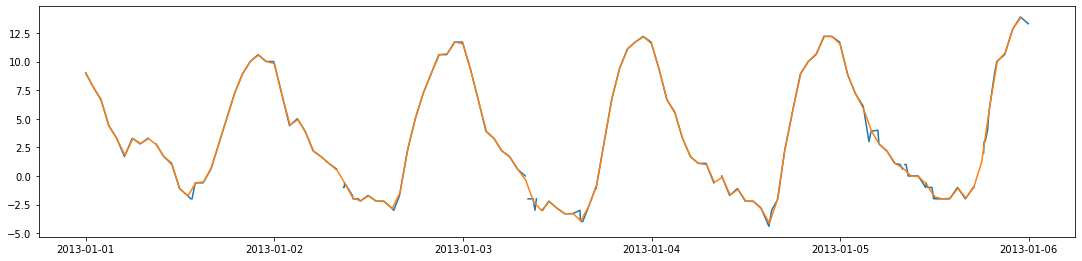

In [18]:
fig = plt.figure(figsize=(16,16))

test = alldat['2013-01-01':'2013-01-05']
test_xr = dathourly.sel(time=slice("2013-01-01","2013-01-05"))
ax = fig.add_axes([0.05,0.7,0.9,0.2])

#ax.plot(test)
ax.plot(test['TMP'])
ax.plot(test_xr.time, test_xr.TMP)

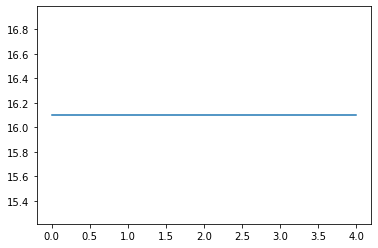

In [264]:
plt.plot(test_xr.TMP)

In [178]:
test = alldat.duplicated(keep='first')

In [193]:
print(len(test))

423514


In [201]:
dt = [datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') for d in alldat['DATE']]
alldat.index = dt

In [212]:
print(alldat['1991-06-06'])

KeyError: '1991-06-06'

In [203]:
testdat=alldat["1991-06-06"]

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


In [204]:
print(testdat)

                                    DATE   TMP   DEW
1991-06-06 00:00:00  1991-06-06T00:00:00  28.9   8.3
1991-06-06 01:00:00  1991-06-06T01:00:00  28.3   8.9
1991-06-06 02:00:00  1991-06-06T02:00:00  26.7   9.4
1991-06-06 03:00:00  1991-06-06T03:00:00  24.4  10.0
1991-06-06 04:00:00  1991-06-06T04:00:00  21.7  12.8
1991-06-06 05:00:00  1991-06-06T05:00:00  20.6  12.8
1991-06-06 06:00:00  1991-06-06T06:00:00  19.4  12.8
1991-06-06 07:00:00  1991-06-06T07:00:00  18.9  12.2
1991-06-06 08:00:00  1991-06-06T08:00:00  18.3  11.7
1991-06-06 09:00:00  1991-06-06T09:00:00  17.8  11.7
1991-06-06 10:00:00  1991-06-06T10:00:00  17.2  11.7
1991-06-06 11:00:00  1991-06-06T11:00:00  16.1  11.7
1991-06-06 12:00:00  1991-06-06T12:00:00  16.1  11.7
1991-06-06 12:15:00  1991-06-06T12:15:00   NaN   NaN
1991-06-06 13:00:00  1991-06-06T13:00:00  16.7  12.8
1991-06-06 14:00:00  1991-06-06T14:00:00  18.3  13.3
1991-06-06 15:00:00  1991-06-06T15:00:00  20.0  13.9
1991-06-06 16:00:00  1991-06-06T16:00:00  21.1

In [207]:
testdup = testdat.index.duplicated(keep='first')

In [208]:
print(testdup)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False]


In [209]:
dropdup = testdat[~testdup]

In [210]:
print(dropdup)

                                    DATE   TMP   DEW
1991-06-06 00:00:00  1991-06-06T00:00:00  28.9   8.3
1991-06-06 01:00:00  1991-06-06T01:00:00  28.3   8.9
1991-06-06 02:00:00  1991-06-06T02:00:00  26.7   9.4
1991-06-06 03:00:00  1991-06-06T03:00:00  24.4  10.0
1991-06-06 04:00:00  1991-06-06T04:00:00  21.7  12.8
1991-06-06 05:00:00  1991-06-06T05:00:00  20.6  12.8
1991-06-06 06:00:00  1991-06-06T06:00:00  19.4  12.8
1991-06-06 07:00:00  1991-06-06T07:00:00  18.9  12.2
1991-06-06 08:00:00  1991-06-06T08:00:00  18.3  11.7
1991-06-06 09:00:00  1991-06-06T09:00:00  17.8  11.7
1991-06-06 10:00:00  1991-06-06T10:00:00  17.2  11.7
1991-06-06 11:00:00  1991-06-06T11:00:00  16.1  11.7
1991-06-06 12:00:00  1991-06-06T12:00:00  16.1  11.7
1991-06-06 12:15:00  1991-06-06T12:15:00   NaN   NaN
1991-06-06 13:00:00  1991-06-06T13:00:00  16.7  12.8
1991-06-06 14:00:00  1991-06-06T14:00:00  18.3  13.3
1991-06-06 15:00:00  1991-06-06T15:00:00  20.0  13.9
1991-06-06 16:00:00  1991-06-06T16:00:00  21.1

In [202]:
print(alldat["1991-06-06"])

                                    DATE   TMP   DEW
1991-06-06 00:00:00  1991-06-06T00:00:00  28.9   8.3
1991-06-06 01:00:00  1991-06-06T01:00:00  28.3   8.9
1991-06-06 02:00:00  1991-06-06T02:00:00  26.7   9.4
1991-06-06 03:00:00  1991-06-06T03:00:00  24.4  10.0
1991-06-06 04:00:00  1991-06-06T04:00:00  21.7  12.8
1991-06-06 05:00:00  1991-06-06T05:00:00  20.6  12.8
1991-06-06 06:00:00  1991-06-06T06:00:00  19.4  12.8
1991-06-06 07:00:00  1991-06-06T07:00:00  18.9  12.2
1991-06-06 08:00:00  1991-06-06T08:00:00  18.3  11.7
1991-06-06 09:00:00  1991-06-06T09:00:00  17.8  11.7
1991-06-06 10:00:00  1991-06-06T10:00:00  17.2  11.7
1991-06-06 11:00:00  1991-06-06T11:00:00  16.1  11.7
1991-06-06 12:00:00  1991-06-06T12:00:00  16.1  11.7
1991-06-06 12:15:00  1991-06-06T12:15:00   NaN   NaN
1991-06-06 13:00:00  1991-06-06T13:00:00  16.7  12.8
1991-06-06 14:00:00  1991-06-06T14:00:00  18.3  13.3
1991-06-06 15:00:00  1991-06-06T15:00:00  20.0  13.9
1991-06-06 16:00:00  1991-06-06T16:00:00  21.1

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


In [184]:
print(alldat["1996-11-01"])

                                    DATE   TMP  DEW
1996-11-01 00:53:00  1996-11-01T00:53:00  15.0  7.8
1996-11-01 01:53:00  1996-11-01T01:53:00  11.7  8.3
1996-11-01 02:53:00  1996-11-01T02:53:00   9.4  7.2
1996-11-01 03:41:00  1996-11-01T03:41:00   8.0  7.0
1996-11-01 03:53:00  1996-11-01T03:53:00   8.3  6.7
1996-11-01 04:19:00  1996-11-01T04:19:00   8.0  6.0
1996-11-01 04:53:00  1996-11-01T04:53:00   7.2  5.6
1996-11-01 05:53:00  1996-11-01T05:53:00   7.2  5.0
1996-11-01 06:53:00  1996-11-01T06:53:00   6.1  3.9
1996-11-01 06:59:00  1996-11-01T06:59:00   NaN  NaN
1996-11-01 07:53:00  1996-11-01T07:53:00   5.6  3.3
1996-11-01 09:00:00  1996-11-01T09:00:00   5.0  2.8
1996-11-01 09:53:00  1996-11-01T09:53:00   5.0  2.2
1996-11-01 10:53:00  1996-11-01T10:53:00   5.6  2.2
1996-11-01 11:53:00  1996-11-01T11:53:00   5.0  1.7
1996-11-01 12:53:00  1996-11-01T12:53:00   5.0  1.7
1996-11-01 13:02:00  1996-11-01T13:02:00   5.0  2.0
1996-11-01 13:53:00  1996-11-01T13:53:00   4.4  1.7
1996-11-01 1

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


In [172]:
print(alldat["1996-11-01"])

                                    DATE   TMP  DEW
1996-11-01 00:53:00  1996-11-01T00:53:00  15.0  7.8
1996-11-01 01:53:00  1996-11-01T01:53:00  11.7  8.3
1996-11-01 02:53:00  1996-11-01T02:53:00   9.4  7.2
1996-11-01 03:41:00  1996-11-01T03:41:00   8.0  7.0
1996-11-01 03:53:00  1996-11-01T03:53:00   8.3  6.7
1996-11-01 04:19:00  1996-11-01T04:19:00   8.0  6.0
1996-11-01 04:53:00  1996-11-01T04:53:00   7.2  5.6
1996-11-01 05:53:00  1996-11-01T05:53:00   7.2  5.0
1996-11-01 06:53:00  1996-11-01T06:53:00   6.1  3.9
1996-11-01 06:59:00  1996-11-01T06:59:00   NaN  NaN
1996-11-01 06:59:00  1996-11-01T06:59:00   NaN  NaN
1996-11-01 07:53:00  1996-11-01T07:53:00   5.6  3.3
1996-11-01 09:00:00  1996-11-01T09:00:00   5.0  2.8
1996-11-01 09:53:00  1996-11-01T09:53:00   5.0  2.2
1996-11-01 10:53:00  1996-11-01T10:53:00   5.6  2.2
1996-11-01 11:53:00  1996-11-01T11:53:00   5.0  1.7
1996-11-01 12:53:00  1996-11-01T12:53:00   5.0  1.7
1996-11-01 13:02:00  1996-11-01T13:02:00   5.0  2.0
1996-11-01 1

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


In [163]:
for i in np.arange(0,1000,1):
    print(alldat.index[i])

1980-01-01 00:00:00
1980-01-01 01:00:00
1980-01-01 02:00:00
1980-01-01 03:00:00
1980-01-01 04:00:00
1980-01-01 05:00:00
1980-01-01 06:00:00
1980-01-01 07:00:00
1980-01-01 08:00:00
1980-01-01 09:00:00
1980-01-01 10:00:00
1980-01-01 11:00:00
1980-01-01 12:00:00
1980-01-01 13:00:00
1980-01-01 14:00:00
1980-01-01 15:00:00
1980-01-01 16:00:00
1980-01-01 17:00:00
1980-01-01 18:00:00
1980-01-01 19:00:00
1980-01-01 20:00:00
1980-01-01 21:00:00
1980-01-01 22:00:00
1980-01-01 23:00:00
1980-01-02 00:00:00
1980-01-02 01:00:00
1980-01-02 02:00:00
1980-01-02 03:00:00
1980-01-02 04:00:00
1980-01-02 05:00:00
1980-01-02 06:00:00
1980-01-02 07:00:00
1980-01-02 08:00:00
1980-01-02 09:00:00
1980-01-02 10:00:00
1980-01-02 11:00:00
1980-01-02 12:00:00
1980-01-02 13:00:00
1980-01-02 14:00:00
1980-01-02 15:00:00
1980-01-02 16:00:00
1980-01-02 17:00:00
1980-01-02 18:00:00
1980-01-02 19:00:00
1980-01-02 20:00:00
1980-01-02 21:00:00
1980-01-02 22:00:00
1980-01-02 23:00:00
1980-01-03 00:00:00
1980-01-03 01:00:00


In [148]:
test = pd.concat(alldat, ignore_index=True).reset_index()

In [162]:
print(len(alldat.index))

423514


In [134]:
dathourly = alldat.resample('H')

In [135]:
print(dathourly)

DatetimeIndexResampler [freq=<Hour>, axis=0, closed=left, label=left, convention=start, origin=start_day]


In [118]:
datdailyxr = xr.DataArray(datdaily['TMP'], dims=['time'])

In [136]:
dathourly = dathourly.interpolate(method='time')

ValueError: cannot reindex from a duplicate axis

In [125]:
print(datout)

<xarray.Dataset>
Dimensions:  (time: 14976)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2020-12-31
Data variables:
    t2m      (time) float64 nan nan nan nan nan ... -0.9958 -0.85 -0.5167 -2.867
    dewp     (time) float64 nan nan nan nan nan ... -4.842 -1.846 -1.458 -4.2


In [129]:
print(datout)

<xarray.Dataset>
Dimensions:  (time: 14965)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2020-12-31
Data variables:
    t2m      (time) float64 nan nan nan nan nan ... -0.9958 -0.85 -0.5167 -2.867
    dewp     (time) float64 nan nan nan nan nan ... -4.842 -1.846 -1.458 -4.2


In [123]:
print(t2m)

<xarray.DataArray 't2m' (time: 14976)>
array([        nan,         nan,         nan, ..., -0.85      ,
       -0.51666667, -2.86666667])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2020-12-31


In [102]:
datdaily = dathourly.resample('D')
datdaily = datdaily.mean()

In [103]:
print(datdaily)

                  index       TMP        DEW
1980-01-01     2.833333 -8.277778 -12.611111
1980-01-02     9.833333 -4.083333  -7.041667
1980-01-03    17.833333 -2.458333  -5.625000
1980-01-04    25.833333 -0.208333  -0.750000
1980-01-05    33.833333 -2.208333  -3.291667
...                 ...       ...        ...
2020-12-27  8590.500000  1.045833  -2.520833
2020-12-28  8614.500000 -0.995833  -4.841667
2020-12-29  8638.500000 -0.850000  -1.845833
2020-12-30  8662.500000 -0.516667  -1.458333
2020-12-31  8686.500000 -2.866667  -4.200000

[14976 rows x 3 columns]


In [80]:
timeout = pd.date_range(start="01-01-"+str(ystart), end="12-31-"+str(yend), freq='H')

In [85]:
test = alldat.resample('H')
test = test.interpolate(method='time')

In [68]:
print(datetime.strptime(alldat['DATE'][0], '%Y-%m-%dT%H:%M:%S'))

1980-01-01 06:00:00


In [88]:
print(test[0:10])

                        index                 DATE        TMP        DEW
1980-01-01 06:00:00  0.000000  1980-01-01T06:00:00  -9.000000 -15.000000
1980-01-01 07:00:00  0.333333                  NaN  -9.000000 -14.666667
1980-01-01 08:00:00  0.666667                  NaN  -9.000000 -14.333333
1980-01-01 09:00:00  1.000000  1980-01-01T09:00:00  -9.000000 -14.000000
1980-01-01 10:00:00  1.333333                  NaN  -9.666667 -14.666667
1980-01-01 11:00:00  1.666667                  NaN -10.333333 -15.333333
1980-01-01 12:00:00  2.000000  1980-01-01T12:00:00 -11.000000 -16.000000
1980-01-01 13:00:00  2.333333                  NaN -10.333333 -15.666667
1980-01-01 14:00:00  2.666667                  NaN  -9.666667 -15.333333
1980-01-01 15:00:00  3.000000  1980-01-01T15:00:00  -9.000000 -15.000000


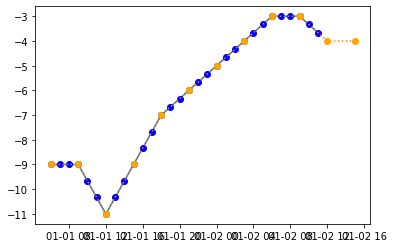

In [98]:
plt.plot(test['TMP'][0:30])
plt.plot(test['TMP'][0:30],"o", color='blue')
plt.plot(alldat['TMP'][0:12], linestyle='dotted')
plt.plot(alldat['TMP'][0:12],"o", color='orange')

In [49]:
import importlib
importlib.reload(isd)
for varname in ('TMP','DEW'):
    test = isd.remove_bad_vals(test, varname)

In [51]:
print(test)

                     DATE  SOURCE REPORT_TYPE CALL_SIGN QUALITY_CONTROL  \
0     1980-01-01T06:00:00       4       FM-12     ENJA             V020   
1     1980-01-01T09:00:00       4       FM-12     ENJA             V020   
2     1980-01-01T12:00:00       4       FM-12     ENJA             V020   
3     1980-01-01T15:00:00       4       FM-12     ENJA             V020   
4     1980-01-01T18:00:00       4       FM-12     ENJA             V020   
...                   ...     ...         ...       ...             ...   
2885  1980-12-31T09:00:00       4       FM-12     ENJA             V020   
2886  1980-12-31T12:00:00       4       FM-12     ENJA             V020   
2887  1980-12-31T15:00:00       4       FM-12     ENJA             V020   
2888  1980-12-31T18:00:00       4       FM-12     ENJA             V020   
2889  1980-12-31T21:00:00       4       FM-12     ENJA             V020   

          TMP      DEW  
0     -0090,1  -0150,1  
1     -0090,1  -0140,1  
2     -0110,1  -0160,1  

In [50]:
print(test2)

                     DATE  SOURCE REPORT_TYPE CALL_SIGN QUALITY_CONTROL  \
0     1980-01-01T06:00:00       4       FM-12     ENJA             V020   
1     1980-01-01T09:00:00       4       FM-12     ENJA             V020   
2     1980-01-01T12:00:00       4       FM-12     ENJA             V020   
3     1980-01-01T15:00:00       4       FM-12     ENJA             V020   
4     1980-01-01T18:00:00       4       FM-12     ENJA             V020   
...                   ...     ...         ...       ...             ...   
2885  1980-12-31T09:00:00       4       FM-12     ENJA             V020   
2886  1980-12-31T12:00:00       4       FM-12     ENJA             V020   
2887  1980-12-31T15:00:00       4       FM-12     ENJA             V020   
2888  1980-12-31T18:00:00       4       FM-12     ENJA             V020   
2889  1980-12-31T21:00:00       4       FM-12     ENJA             V020   

          TMP   DEW  
0     -0090,1 -15.0  
1     -0090,1 -14.0  
2     -0110,1 -16.0  
3     -0090

In [43]:
df = data
for varname in ('TMP','DEW'):
    flag = np.array([d.split(',')[-1] for d in df[varname]])
    
    sys.exit()

SystemExit: 

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3532: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [44]:
print(flag)

['1' '1' '1' ... '1' '1' '1']


In [35]:
print(date_data['TMP'].split(",")[-1])

AttributeError: 'Series' object has no attribute 'split'

In [36]:
test = date_data['TMP']

In [38]:
print(test.split(',')[0])

AttributeError: 'Series' object has no attribute 'split'